This notebook implements strategy number 2.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.grid import Grid
import random
import multiprocessing
from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

As input data we use consumption/production of specific houses, that were found to have reasonable consumption/production quantities. Also we set the timeframe to a short one of two weeks, such that the genetic algorithm runs faster than for a whole year.

In [47]:
# Consumption data
df_cons = pd.read_csv('data/consumption_ausgrid.csv')
df_cons['Unnamed: 0'] = pd.to_datetime(df_cons['Unnamed: 0'])
df_cons = df_cons.set_index('Unnamed: 0')
df_cons_red = df_cons.iloc[:,0]
# Production data
df_prod = pd.read_csv('data/generation_ausgrid.csv')
df_prod['Unnamed: 0'] = pd.to_datetime(df_prod['Unnamed: 0'])
df_prod = df_prod.set_index('Unnamed: 0')

# Choose specific houses and time frame
used_houses = [114,204,47,160,82,168]# Good ones are until 168
used_houses = random.sample(list(np.arange(df_cons.shape[1])),50)
week_start = 37
week_end = 39
df_cons = df_cons.iloc[7*48*week_start:7*48*week_end,used_houses]
df_prod = df_prod.iloc[7*48*week_start:7*48*week_end,used_houses]

data_cons = df_cons.values
data_prod = df_prod.values

Now we can build the grid model. Since we only simulate 2 weeks, we need to set the costs accordingly. Therfore we define the timeframe after which the storages should pay off (i.e. 10 years) and calculate its investition cost for two weeks. 

In [48]:
# Create grid model
g = Grid(num_houses=df_cons.shape[1],
         num_storages=1,
         max_capacity=0,
         num_pvtypes=df_prod.shape[1],
         pv_peakpower=0)
# Add each pv type to each house
for i in range(df_cons.shape[1]):
    g.change_pvtype(num_house=i,pv_type=i)

# Set the costs for 2 weeks
amortization_timeframe = 10*365 # in days
storage_cost_per_kWh = 500
storage_cost_per_kWh_per_day = storage_cost_per_kWh / amortization_timeframe
cost_per_wire = 0 # Assume wires are already there
loss_per_unit = 0.05 # 5% of power lost, when transferring to direct neighbor
g.set_costs(cost_storage_kwh=14*storage_cost_per_kWh_per_day,loss_per_unit=loss_per_unit)

# Simulate the grid
res_dict_wo_storage = g.simulate(data_cons=data_cons,data_prod=data_prod)
print(res_dict_wo_storage)

{'import_grid_kwh': 7742.280497499896, 'export_grid_kwh': 1319.0736125000014, 'pv_production_kwh': 4497.89599999998, 'setup_cost_storage': 0.0, 'setup_cost_pv': 0.0, 'cost_import_grid': 1935.570124374974, 'reward_export_grid': 131.90736125000015}


As we can see there is something going on with pv production and export. We still need an objective function that returns the cost for running this kind of grid for the specific timeframe. In this case the objective function is really easy, since we already defined the cost for setting up the storages in this two week interval.

In [49]:
def objective_function(res_dict):
    return res_dict['cost_import_grid'] + res_dict['setup_cost_storage'] - res_dict['reward_export_grid']

# Calculate the cost of the above simulation
cost_wo_storage = objective_function(res_dict_wo_storage)
print('Cost without storage: ' + str(cost_wo_storage))

Cost without storage: 1803.662763124974


Now we can setup the storage system and calculate the expenses again. Therefore we first observe the boundary case of everyone has its own storage, hence the losses in the system are reduced.

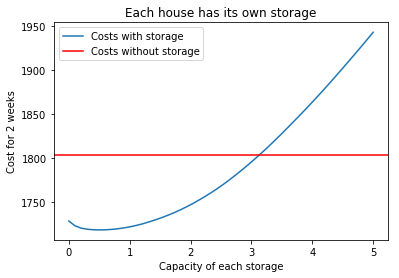

In [50]:
# Create grid with all and with one storage
g.change_storages(num_storages=data_cons.shape[1],max_capacity=0)
# connect each house to its own storage
for i in range(data_cons.shape[1]):
    g.change_storage_connection(num_house=i,storage_connection=i)
# Capacities to simulate
caps = np.linspace(0,5,50,dtype=float)
costs = np.array([])
for cap in caps:
    g.change_storages(num_storages=data_cons.shape[1],max_capacity=cap)
    for i in range(data_cons.shape[1]):
        g.change_storage_connection(num_house=i,storage_connection=i)
    costs = np.append(costs,objective_function(g.simulate(data_cons,data_prod)))
min_cost_all_storages = np.min(costs)
plt.plot(caps,costs,label='Costs with storage')
plt.axhline(cost_wo_storage,label='Costs without storage',c='r')
plt.xlabel('Capacity of each storage')
plt.ylabel('Cost for 2 weeks')
plt.legend()
plt.title('Each house has its own storage')
plt.show()

Now we observe the other boundary case in which we only have one storage. So there is maximum sharing, but also a maximum cost for connections to the storage.

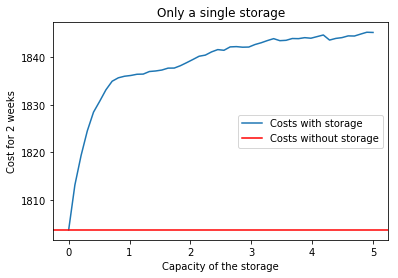

In [51]:
# Create grid with all and with one storage
g.change_storages(num_storages=1,max_capacity=0)
caps = np.linspace(0,5,50)
costs = np.array([])

for cap in caps:
    g.change_storages(num_storages=1,max_capacity=cap)
    costs = np.append(costs,objective_function(g.simulate(data_cons,data_prod)))
min_cost_one_storage = np.min(costs)    
plt.plot(caps,costs,label='Costs with storage')
plt.xlabel('Capacity of the storage')
plt.ylabel('Cost for 2 weeks')
plt.axhline(cost_wo_storage,label='Costs without storage',c='r')
plt.legend()
plt.title('Only a single storage')
plt.show()

The optimal solution might exist some where in between of these two boundary cases. Therefore we implement a genetic algorithm, to search for this optimal solution within the large state space. The parameters we can change are the number of storages, their sizes and the connection of the houses to the storages.

In [52]:
# Create a initial population
population_size = 200
population = []
costs_population = []
for i in range(population_size):
    g = Grid(num_houses=data_cons.shape[1],
             num_storages=data_cons.shape[1],
             max_capacity=10,
             num_pvtypes=data_prod.shape[1],
             pv_peakpower=0)
    # Set the costs for 2 weeks
    amortization_timeframe = 10*365 # in days
    storage_cost_per_kWh = 500
    storage_cost_per_kWh_per_day = storage_cost_per_kWh / amortization_timeframe
    cost_per_wire = 0 # Assume wires are already there
    loss_per_unit = 0.05 # 5% of power lost, when transferring to direct neighbor
    g.set_costs(cost_storage_kwh=14*storage_cost_per_kWh_per_day,loss_per_unit=loss_per_unit)
    g.randomize()
    # Add each pv type to each house
    for i in range(df_cons.shape[1]):
        g.change_pvtype(num_house=i,pv_type=i)
    # Append individual to population
    population.append(g)

# Calculate the objective function for each individual 
def get_cost(individual):
    return objective_function(individual.simulate(data_cons,data_prod))

# Use multiprocessing to speed up this calculation
pool = multiprocessing.Pool(100)
costs_population = pool.map(get_cost,population)
print('Initialized population')

Initialized population


The genetic algorithm needs no certain probabilities that will change the setup of the grid system. We give mutation and crossover probabilities to two different properties:

    storage connections
    storage capacity
    
We could also edit the number of storages, but a storage can simply be excluded by not connecting any house to them. Therefore we don't need to explicitly take that into account. The objective function automatically excludes the setup costs for storages that are not used by the grid.
    

In [53]:
# Probabilities
prob_mut_connection = 0.25
prob_mut_capacity = 0.25
prob_cross_connection = 0.25
prob_cross_capacity = 0.25

# Other properties of the GA
num_generations = 20

# Mean and min 
mean_costs = np.zeros(num_generations)
min_costs = np.zeros(num_generations)
# Progressbar print
print('|{}|'.format(' ' * (num_generations - 2)))
# TODO: Check that the copy function works
# Loop through generations
for i in range(num_generations):
    # Update progress bar
    print('*',end='',flush=True)
    # Create mutations for connections
    idx = random.sample(list(np.arange(population_size)),int(prob_mut_connection*population_size))
    for k in idx:
        g_copy = population[k].get_copy()
        g_copy.mutate(num_house=-1,storage_connection=True)
        population.append(g_copy)
    # Create mutations for capacities
    # TODO: This just decreases the size of the actual maximum capacity
    idx = random.sample(list(np.arange(population_size)),int(prob_mut_capacity*population_size))
    for k in idx:
        g_copy = population[k].get_copy()
        g_copy.mutate(num_house=-1,storage_sizes=True)
        population.append(g_copy)
    # Create crossovers for connection
    idx1 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    idx2 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    for j,k in zip(idx1,idx2):
        g_copy = population[j].get_copy()
        g_copy2 = g_copy.crossover(population[k],storage_connection=True)
        population.append(g_copy)
        population.append(g_copy2)
    # Create crossovers for capacity
    idx1 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    idx2 = random.sample(list(np.arange(population_size)),int(prob_cross_connection/2*population_size))
    for j,k in zip(idx1,idx2):
        g_copy = population[j].get_copy()
        g_copy2 = g_copy.crossover(population[k],storage_sizes=True)
        population.append(g_copy)
        population.append(g_copy2)
    
    # Calculate objective functions of the new populations
    new_costs = pool.map(get_cost,population[population_size:])
    costs_population = np.append(costs_population,new_costs)
    
    # Get the sorting indices
    sort_idx = np.argsort(costs_population)
    del_idx = sort_idx[population_size:]
    # Remove the individuals with too high costs
    for index in sorted(del_idx, reverse=True):
        del population[index]
    # Remove their costs from the population costs
    costs_population = costs_population[sort_idx[:population_size]]
    
    mean_costs[i] = np.mean(costs_population)
    min_costs[i] = np.min(costs_population)

|                  |
********************

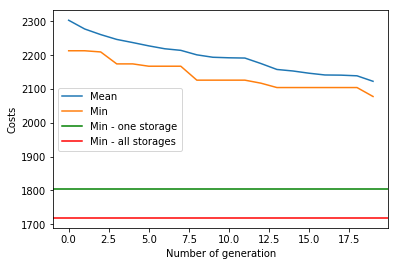

In [54]:
plt.plot(mean_costs,label='Mean')
plt.plot(min_costs,label='Min')
plt.axhline(min_cost_one_storage,c='g',label='Min - one storage')
plt.axhline(min_cost_all_storages,c='r',label='Min - all storages')
plt.xlabel('Number of generation')
plt.ylabel('Costs')
plt.legend()
plt.show()

In [55]:
population[ß]

0